In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import RNN, Layer
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow import float32, concat, convert_to_tensor, linalg

2023-06-16 13:10:51.216583: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 13:10:51.273399: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-16 13:10:55.831805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class RungeKuttaIntegratorCell(Layer):
    def __init__(self, m, c, k, dt, initial_state, **kwargs):
        super(RungeKuttaIntegratorCell, self).__init__(**kwargs)
        self.Minv = linalg.inv(np.diag(m))
        self._c   = c
        self.K    = self._getCKmatrix(k)
        self.initial_state = initial_state
        self.state_size    = 2*len(m)
        self.A  = np.array([0., 0.5, 0.5, 1.0], dtype='float32')
        self.B  = np.array([[1/6, 2/6, 2/6, 1/6]], dtype='float32')
        self.dt = dt

    def build(self, input_shape, **kwargs):
        self.kernel = self.add_weight("C", shape = self._c.shape, trainable = True, initializer = lambda shape, dtype: self._c, **kwargs)
        self.built  = True

    def call(self, inputs, states):
        C    = self._getCKmatrix(self.kernel)
        y    = states[0][:,:2]
        ydot = states[0][:,2:]
        yddoti = self._fun(self.Minv, self.K, C, inputs, y, ydot)
        yi     = y + self.A[0] * ydot * self.dt
        ydoti  = ydot + self.A[0] * yddoti * self.dt
        fn     = self._fun(self.Minv, self.K, C, inputs, yi, ydoti)
        for j in range(1,4):
            yn    = y + self.A[j] * ydot * self.dt
            ydotn = ydot + self.A[j] * yddoti * self.dt
            ydoti = concat([ydoti, ydotn], axis=0)
            fn    = concat([fn, self._fun(self.Minv, self.K, C, inputs, yn, ydotn)], axis=0)

        y    = y + linalg.matmul(self.B, ydoti) * self.dt
        ydot = ydot + linalg.matmul(self.B, fn) * self.dt
        return y, [concat(([y, ydot]), axis=-1)]

    def _fun(self, Minv, K, C, u, y, ydot):
        return linalg.matmul(u - linalg.matmul(ydot, C, transpose_b=True) - linalg.matmul(y, K, transpose_b=True), Minv, transpose_b=True)

    def _getCKmatrix(self, a):
        return convert_to_tensor([[a[0]+a[1],-a[1]],[-a[1],a[1]+a[2]]], dtype=float32)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return self.initial_state


In [3]:
def create_model(m, c, k, dt, initial_state, batch_input_shape, return_sequences = True, unroll = False):
    rkCell = RungeKuttaIntegratorCell(m=m, c=c, k=k, dt=dt, initial_state=initial_state)
    PINN   = RNN(cell=rkCell, batch_input_shape=batch_input_shape, return_sequences=return_sequences, return_state=False, unroll=unroll)
    model  = Sequential()
    model.add(PINN)
    model.compile(loss='mse', optimizer=RMSprop(1e4), metrics=['mae'])
    return model

2023-06-16 13:12:10.620751: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-16 13:12:11.124156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1,1001,2]
	 [[{{node Placeholder/_0}}]]


Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.1582e-08 - mae: 7.9297e-05
Epoch 2/100
1/1 [==============================] - 0s 271ms/step - loss: 1.1569e-08 - mae: 7.9251e-05
Epoch 3/100
1/1 [==============================] - 0s 261ms/step - loss: 1.1556e-08 - mae: 7.9205e-05
Epoch 4/100
1/1 [==============================] - 0s 262ms/step - loss: 1.1543e-08 - mae: 7.9159e-05
Epoch 5/100
1/1 [==============================] - 0s 268ms/step - loss: 1.1530e-08 - mae: 7.9113e-05
Epoch 6/100
1/1 [==============================] - 0s 317ms/step - loss: 1.1517e-08 - mae: 7.9067e-05
Epoch 7/100
1/1 [==============================] - 0s 268ms/step - loss: 1.1504e-08 - mae: 7.9021e-05
Epoch 8/100
1/1 [==============================] - 0s 268ms/step - loss: 1.1491e-08 - mae: 7.8976e-05
Epoch 9/100
1/1 [==============================] - 0s 261ms/step - loss: 1.1479e-08 - mae: 7.8930e-05
Epoch 10/100
1/1 [==============================] - 0s 258ms/step - loss: 1.1466e-08 

2023-06-16 13:12:40.759913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1,1001,2]
	 [[{{node Placeholder/_0}}]]


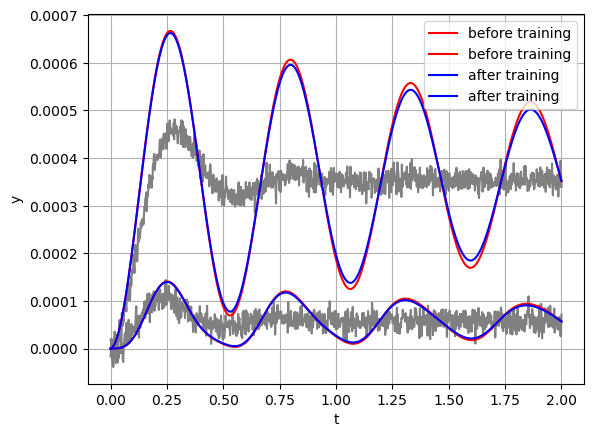

In [4]:
if __name__ == "__main__":
    # masses, spring coefficients, and damping coefficients
    m = np.array([20.0, 10.0], dtype='float32')
    c = np.array([10.0, 10.0, 10.0], dtype='float32') # initial guess
    k = np.array([2e3, 1e3, 5e3], dtype='float32')

    # data
    df = pd.read_csv('./data.csv')
    t  = df[['t']].values
    dt = (t[1] - t[0])[0]
    utrain = df[['u0', 'u1']].values[np.newaxis, :, :]
    ytrain = df[['yT0', 'yT1']].values[np.newaxis, :, :]

    # fitting physics-informed neural network
    initial_state = np.zeros((1,2 * len(m),), dtype='float32')
    model = create_model(m, c, k, dt, initial_state=initial_state, batch_input_shape=utrain.shape)
    yPred_before = model.predict_on_batch(utrain)[0, :, :]
    model.fit(utrain, ytrain, epochs=100, steps_per_epoch=1, verbose=1)
    yPred = model.predict_on_batch(utrain)[0, :, :]

    # plotting prediction results
    plt.plot(t, ytrain[0, :, :], 'gray')
    plt.plot(t, yPred_before[:, :], 'r', label='before training')
    plt.plot(t, yPred[:, :], 'b', label='after training')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.grid('on')
    plt.legend()
    plt.show()
